In [ ]:
#| hide
!pip install -Uqq nixtla

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Why TimeGPT?

In this notebook, we compare the performance of TimeGPT against three forecasting models: the classical model (ARIMA), the machine learning model (LightGBM), and the deep learning model (N-HiTS), using a subset of data from the M5 Forecasting competition. We want to highlight three top-rated benefits our users love about TimeGPT:

🎯 **Accuracy**: TimeGPT consistently outperforms traditional models by capturing complex patterns with precision.

⚡ **Speed**: Generate forecasts faster without needing extensive training or tuning for each series.

🚀 **Ease of Use**: Minimal setup and no complex preprocessing make TimeGPT accessible and ready to use right out of the box!

Before diving into the notebook, please visit our [dashboard](https://dashboard.nixtla.io) to generate your TimeGPT `api_key` and give it a try yourself!

# Table of Contents

1. [Data Introduction](#1-data-introduction)
2. [Model Fitting](#2-model-fitting-timegpt-arima-lightgbm-n-hits)
    1. [Fitting TimeGPT](#21-timegpt)
    2. [Fitting ARIMA](#22-classical-models-arima)
    3. [Fitting Light GBM](#23-machine-learning-models-lightgbm)
    4. [Fitting NHITS](#24-n-hits)
3. [Results and Evaluation](#3-performance-comparison-and-results)
4. [Conclusion](#4-conclusion)

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/getting-started/7_why_timegpt')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/getting-started/7_why_timegpt.ipynb)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nixtla import NixtlaClient
from utilsforecast.plotting import plot_series
from utilsforecast.losses import mae, rmse, smape
from utilsforecast.evaluation import evaluate

In [ ]:
nixtla_client = NixtlaClient(
    # api_key = 'my_api_key_provided_by_nixtla'
)

## 1. Data introduction

In this notebook, we’re working with an aggregated dataset from the M5 Forecasting - Accuracy competition. This dataset includes **7 daily time series**, each with **1,941 data points**. The last **28 data points** of each series are set aside as the test set, allowing us to evaluate model performance on unseen data.

In [ ]:
df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/demand_example.csv', parse_dates=['ds'])

In [ ]:
df.groupby('unique_id').agg({"ds":["min","max","count"],\
                             "y":["min","mean","median","max"]})

ds                      y                                
                   min        max count   min          mean   median      max
unique_id                                                                    
FOODS_1     2011-01-29 2016-05-22  1941   0.0   2674.085523   2665.0   5493.0
FOODS_2     2011-01-29 2016-05-22  1941   0.0   4015.984029   3894.0   9069.0
FOODS_3     2011-01-29 2016-05-22  1941  10.0  16969.089129  16548.0  28663.0
HOBBIES_1   2011-01-29 2016-05-22  1941   0.0   2936.122617   2908.0   5009.0
HOBBIES_2   2011-01-29 2016-05-22  1941   0.0    279.053065    248.0    871.0
HOUSEHOLD_1 2011-01-29 2016-05-22  1941   0.0   6039.594539   5984.0  11106.0
HOUSEHOLD_2 2011-01-29 2016-05-22  1941   0.0   1566.840289   1520.0   2926.0

In [ ]:
df_train = df.query('ds <= "2016-04-24"')
df_test = df.query('ds > "2016-04-24"')

print(df_train.shape, df_test.shape)

(13391, 3) (196, 3)


## 2. Model Fitting (TimeGPT, ARIMA, LightGBM, N-HiTS)

### 2.1 TimeGPT
TimeGPT offers a powerful, streamlined solution for time series forecasting, delivering state-of-the-art results with minimal effort. With TimeGPT, there's no need for data preprocessing or feature engineering -- simply initiate the Nixtla client and call `nixtla_client.forecast` to produce accurate, high-performance forecasts tailored to your unique time series.


In [ ]:
# Forecast with TimeGPT
fcst_timegpt = nixtla_client.forecast(df = df_train,
                       target_col = 'y', 
                       h=28,                              # Forecast horizon, predicts the next 28 time steps
                       model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
                       finetune_steps=10,                 # Number of finetuning steps
                       level = [90])                      # Generate a 90% confidence interval

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [ ]:
# Evaluate performance and plot forecast
fcst_timegpt['ds'] = pd.to_datetime(fcst_timegpt['ds'])
test_df = pd.merge(df_test, fcst_timegpt, 'left', ['unique_id', 'ds'])
evaluation_timegpt = evaluate(test_df, metrics=[rmse, smape], models=["TimeGPT"])
evaluation_timegpt.groupby(['metric'])['TimeGPT'].mean()

metric
rmse     592.607378
smape      0.049403
Name: TimeGPT, dtype: float64

### 2.2 Classical Models (ARIMA):
Next, we applied ARIMA, a traditional statistical model, to the same forecasting task. Classical models use historical trends and seasonality to make predictions by relying on linear assumptions. However, they struggled to capture the complex, non-linear patterns within the data, leading to lower accuracy compared to other approaches. Additionally, ARIMA was slower due to its iterative parameter estimation process, which becomes computationally intensive for larger datasets.

> 📘 Why Use TimeGPT over Classical Models?
>
> * **Complex Patterns**: TimeGPT captures non-linear trends classical models miss.
>
> * **Minimal Preprocessing**: TimeGPT requires little to no data preparation.
>
> * **Scalability**: TimeGPT can efficiently scales across multiple series without retraining.

In [ ]:
#| eval: false
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

In [ ]:
#| eval: false
#Initiate ARIMA model
sf = StatsForecast(
    models=[AutoARIMA(season_length=7)],
    freq='D'
)
# Fit and forecast
fcst_arima = sf.forecast(h=28, df=df_train) 

In [ ]:
#| hide
fcst_arima = pd.read_csv('../../assets/arima_rst.csv', parse_dates=['ds'])

In [ ]:
fcst_arima.reset_index(inplace=True)
test_df = pd.merge(df_test, fcst_arima, 'left', ['unique_id', 'ds'])
evaluation_arima = evaluate(test_df, metrics=[rmse, smape], models=["AutoARIMA"])
evaluation_arima.groupby(['metric'])['AutoARIMA'].mean()

metric
rmse     724.957364
smape      0.055018
Name: AutoARIMA, dtype: float64

### 2.3 Machine Learning Models (LightGBM)

Thirdly, we used a machine learning model, LightGBM, for the same forecasting task, implemented through the automated pipeline provided by our mlforecast library.
While LightGBM can capture seasonality and patterns, achieving the best performance often requires detailed feature engineering, careful hyperparameter tuning, and domain knowledge. You can try our mlforecast library to simplify this process and get started quickly!

> 📘 Why Use TimeGPT over Machine Learning Models?
>
> * **Automatic Pattern Recognition**: Captures complex patterns from raw data, bypassing the need for feature engineering.
>
> * **Minimal Tuning**: Works well without extensive tuning.
>
> * **Scalability**: Forecasts across multiple series without retraining.

In [ ]:
#| eval: false
import optuna
from mlforecast.auto import AutoMLForecast, AutoLightGBM

# Suppress Optuna's logging output
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [ ]:
#| eval: false
# Initialize an automated forecasting pipeline using AutoMLForecast.
mlf = AutoMLForecast(
    models=[AutoLightGBM()],
    freq='D',
    season_length=7,            
    fit_config=lambda trial: {'static_features': ['unique_id']}
)

# Fit the model to the training dataset.
mlf.fit(
    df=df_train.astype({'unique_id': 'category'}),
    n_windows=1,
    h=28,
    num_samples=10,
)
fcst_lgbm = mlf.predict(28)

In [ ]:
#| hide
fcst_lgbm = pd.read_csv('../../assets/lgbm_rst.csv', parse_dates=['ds'])

In [ ]:
test_df = pd.merge(df_test, fcst_lgbm, 'left', ['unique_id', 'ds'])
evaluation_lgbm = evaluate(test_df, metrics=[rmse, smape], models=["AutoLightGBM"])
evaluation_lgbm.groupby(['metric'])['AutoLightGBM'].mean()

metric
rmse     687.773744
smape      0.051448
Name: AutoLightGBM, dtype: float64

### 2.4 N-HiTS

Lastly, we used N-HiTS, a state-of-the-art deep learning model designed for time series forecasting. The model produced accurate results, demonstrating its ability to capture complex, non-linear patterns within the data. However, setting up and tuning N-HiTS required significantly more time and computational resources compared to TimeGPT.

> 📘 Why Use TimeGPT Over Deep Learning Models?
>
> * **Faster Setup**: Quick setup and forecasting, unlike the lengthy configuration and training times of neural networks.
>
> * **Less Tuning**: Performs well with minimal tuning and preprocessing, while neural networks often need extensive adjustments.
>
> * **Ease of Use**: Simple deployment with high accuracy, making it accessible without deep technical expertise.

In [ ]:
#| eval: false
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS

In [ ]:
#| eval: false
# Initialize the N-HiTS model.
models = [NHITS(h=28, 
                input_size=28, 
                max_steps=100)]

# Fit the model using training data
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=df_train)
fcst_nhits = nf.predict()

In [ ]:
#| hide
fcst_nhits = pd.read_csv('../../assets/nhits_rst.csv', parse_dates=['ds'])

In [ ]:
test_df = pd.merge(df_test,fcst_nhits, 'left', ['unique_id', 'ds'])
evaluation_nhits = evaluate(test_df, metrics=[rmse, smape], models=["NHITS"])
evaluation_nhits.groupby(['metric'])['NHITS'].mean()

metric
rmse     605.011948
smape      0.053446
Name: NHITS, dtype: float64

## 3. Performance Comparison and Results:
The performance of each model is evaluated using RMSE (Root Mean Squared Error) and SMAPE (Symmetric Mean Absolute Percentage Error). While RMSE emphasizes the models’ ability to control significant errors, SMAPE provides a relative performance perspective by normalizing errors as percentages. Below, we present a snapshot of performance across all groups. The results demonstrate that TimeGPT outperforms other models on both metrics.

🌟 For a deeper dive into benchmarking, check out our benchmark repository. The summarized results are displayed below:

#### Overall Performance Metrics

| **Model**        | **RMSE** | **SMAPE** |
|------------------|----------|-----------|
| ARIMA            | 724.9   | 5.50%     |
| LightGBM     | 687.8    | 5.14%     |
| N-HiTS           | 605.0    | 5.34%     |
| **TimeGPT**      | **592.6**| **4.94%** |
 

#### Breakdown for Each Time-series
Followed below are the metrics for each individual time series groups. TimeGPT consistently delivers accurate forecasts across all time series groups. In many cases, it performs as well as or better than data-specific models, showing its versatility and reliability across different datasets.

In [ ]:
#| echo: false
evaluation_df = evaluation_arima.merge(evaluation_lgbm, on = ['unique_id','metric'], how = 'left')\
                 .merge(evaluation_nhits, on = ['unique_id','metric'], how = 'left')\
                 .merge(evaluation_timegpt, on = ['unique_id','metric'], how = 'left')

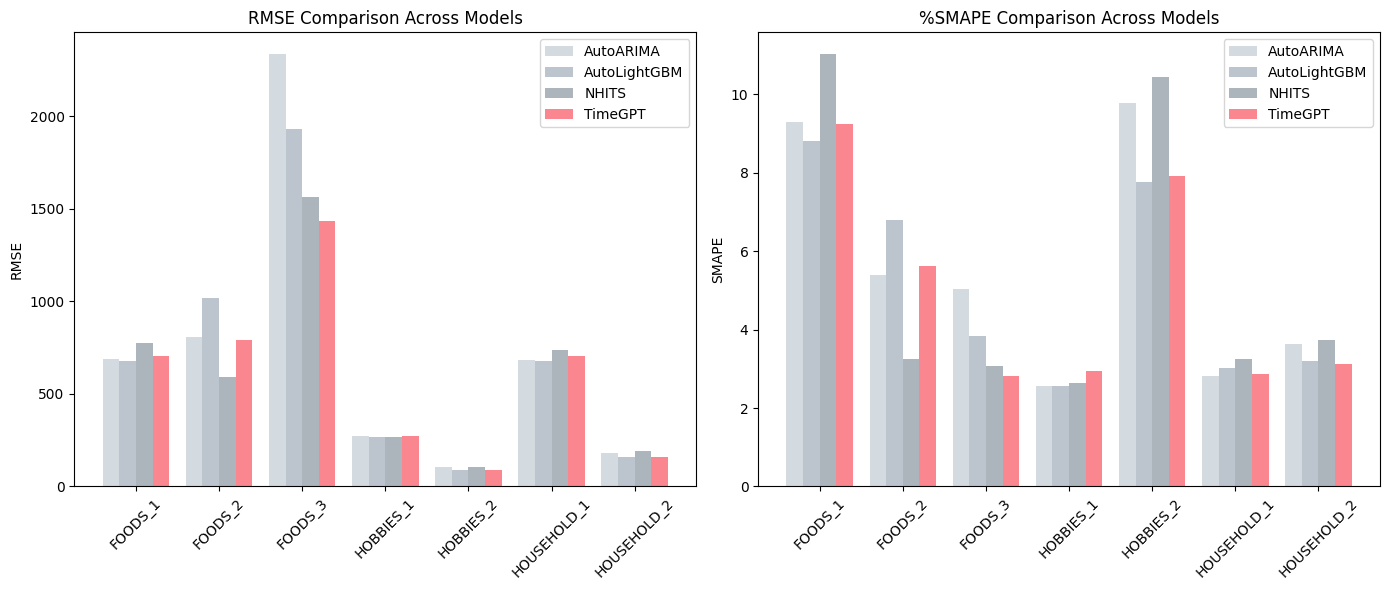

In [ ]:
# | echo: false
colors = [
    ("#A9B9C3", 0.5),  # Grey-bluish color 1
    ("#7A8D9D", 0.5),  # Grey-bluish color 2
    ("#5B6D79", 0.5),  # Grey-bluish color 3
    ('#F95D6A', 0.75)   # Green color for the last
]


# Filter evaluation data by metric and set unique_id as index
rmse_df = evaluation_df[evaluation_df['metric'] == 'rmse'].set_index('unique_id')
smape_df = evaluation_df[evaluation_df['metric'] == 'smape'].set_index('unique_id')

# Plot function with custom colors and opacity
def plot_metric(ax, df, title, ylabel):
    x = np.arange(len(df))
    bar_width = 0.2
    for i, (col, (color, alpha)) in enumerate(zip(df.columns[1:], colors)):
        ax.bar(x + i * bar_width, df[col], width=bar_width, label=col, color=color, alpha=alpha)
    ax.set(title=title, ylabel=ylabel, xticks=x + bar_width * (len(df.columns[1:]) - 1) / 2, xticklabels=df.index)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

# Generate side-by-side plots for RMSE and SMAPE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_metric(axes[0], rmse_df, "RMSE Comparison Across Models", "RMSE")
plot_metric(axes[1], smape_df*100, "%SMAPE Comparison Across Models", "SMAPE")

plt.tight_layout()
plt.show()
     

#### Benchmark Results
For a more comprehensive dive into model accuracy and performance, explore our [Time Series Model Arena](https://github.com/Nixtla/nixtla/tree/main/experiments/foundation-time-series-arena)! TimeGPT continues to lead the pack with exceptional performance across benchmarks! 🌟

<img src="https://github.com/Nixtla/nixtla/blob/main/nbs/img/timeseries_model_arena.png?raw=true" alt="Benchmark" />

## 4. Conclusion
At the end of this notebook, we’ve put together a handy table to show you exactly where TimeGPT shines brightest compared to other forecasting models. ☀️ Think of it as your quick guide to choosing the best model for your unique project needs. We’re confident that TimeGPT will be a valuable tool in your forecasting journey. Don’t forget to visit our [dashboard](https://dashboard.nixtla.io) to generate your TimeGPT `api_key` and get started today! Happy forecasting, and enjoy the insights ahead! 

<table>
  <thead>
    <tr>
      <th>Scenario</th>
      <th>TimeGPT</th>
      <th>Classical Models (e.g., ARIMA)</th>
      <th>Machine Learning Models (e.g., XGB, LGBM)</th>
      <th>Deep Learning Models (e.g., N-HITS)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Seasonal Patterns</td>
      <td>✅ Performs well with minimal setup</td>
      <td>✅ Handles seasonality with adjustments (e.g., SARIMA)</td>
      <td>✅ Performs well with feature engineering</td>
      <td>✅ Captures seasonal patterns effectively</td>
    </tr>
    <tr>
      <td>Non-Linear Patterns</td>
      <td>✅ Excels, especially with complex non-linear patterns</td>
      <td>❌ Limited performance</td>
      <td>❌ Struggles without extensive feature engineering</td>
      <td>✅ Performs well with non-linear relationships</td>
    </tr>
    <tr>
      <td>Large Dataset</td>
      <td>✅ Highly scalable across many series</td>
      <td>❌ Slow and resource-intensive</td>
      <td>✅ Scalable with optimized implementations</td>
      <td>❌ Requires significant resources for large datasets</td>
    </tr>
    <tr>
      <td>Small Dataset</td>
      <td>✅ Performs well; requires only one data point to start</td>
      <td>✅ Performs well; may struggle with very sparse data</td>
      <td>✅ Performs adequately if enough features are extracted</td>
      <td>❌ May need a minimum data size to learn effectively</td>
    </tr>
    <tr>
      <td>Preprocessing Required</td>
      <td>✅ Minimal preprocessing needed</td>
      <td>❌ Requires scaling, log-transform, etc., to meet model assumptions.</td>
      <td>❌ Requires extensive feature engineering for complex patterns</td>
      <td>❌ Needs data normalization and preprocessing</td>
    </tr>
    <tr>
      <td>Accuracy Requirement</td>
      <td>✅ Achieves high accuracy with minimal tuning</td>
      <td>❌ May struggle with complex accuracy requirements</td>
      <td>✅ Can achieve good accuracy with tuning</td>
      <td>✅ High accuracy possible but with significant resource use</td>
    </tr>
    <tr>
      <td>Scalability</td>
      <td>✅ Highly scalable with minimal task-specific configuration</td>
      <td>❌ Not easily scalable</td>
      <td>✅ Moderate scalability, with feature engineering and tuning per task</td>
      <td>❌ Limited scalability due to resource demands</td>
    </tr>
    <tr>
      <td>Computational Resources</td>
      <td>✅ Highly efficient, operates seamlessly on CPU, no GPU needed</td>
      <td>✅ Light to moderate, scales poorly with large datasets</td>
      <td>❌ Moderate, depends on feature complexity</td>
      <td>❌ High resource consumption, often requires GPU</td>
    </tr>
    <tr>
      <td>Memory Requirement</td>
      <td>✅ Efficient memory usage for large datasets</td>
      <td>✅ Moderate memory requirements</td>
      <td>❌ High memory usage for larger datasets or many series cases</td>
      <td>❌ High memory consumption for larger datasets and multiple series</td>
    </tr>
    <tr>
      <td>Technical Requirements & Domain Knowledge</td>
      <td>✅ Low; minimal technical setup and no domain expertise needed</td>
      <td>✅ Low to moderate; needs understanding of stationarity</td>
      <td>❌ Moderate to high; requires feature engineering and tuning</td>
      <td>❌ High; complex architecture and tuning</td>
    </tr>
  </tbody>
</table>
